## 1. Script Description and Imports

In [1]:

# chess_scraper.py
# Description: This script scrapes chess games from the chess.com game archive page.
# Author: Edward
# Date: 2024-08-16

from selenium import webdriver

options = webdriver.ChromeOptions()
options.add_argument("--headless")
driver = webdriver.Chrome(options=options)

from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import json
import time
import re
import csv
from googleapiclient.discovery import build
from google.oauth2.service_account import Credentials

## 2. Constants and Setup

In [2]:
USERNAME = "jlee2327"

def setup_driver():
    """Sets up the Selenium WebDriver with Chrome options."""
    chrome_options = Options()
    chrome_options.add_argument("--disable-javascript")
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    return webdriver.Chrome(options=chrome_options)


## 3. Game Data Extraction

In [3]:

def extract_game_info(row):
    """Extracts relevant game information from a table row."""
    columns = row.find_all('td')
    if len(columns) <= 1:
        return None

    #white_info = columns[0].text.strip() ## This gives you the time control
    names_and_ratings = columns[1].text.strip()
    player_name, player_rating, opponent_name, opponent_rating, player_color, opponent_color = parse_player_info(names_and_ratings)

    accuracies = columns[3].text.strip().split()
    player_accuracy, opponent_accuracy = extract_accuracies(accuracies, player_color)

    result_text = columns[2].text.strip()
#     print(columns[2].text.strip())
    game_result = determine_game_result(result_text, player_color)

    game_link = extract_game_link(row)
    #games_moves = scrape_games_from_game_links(driver, game_link)
    '''print(f"Debugging: Printing Game MOves: {games_moves}")'''

    if not game_link:
        return None  # Skip rows without a game link

    player_country, opponent_country = extract_countries(row)
    

    game_data = {
        'Game_Type': columns[0].text.strip(),
        'Result': game_result,
        'Accuracies': columns[3].text.strip(),
        'Total_Moves': columns[4].text.strip(),
        'Date': columns[5].text.strip(),
        'Link': game_link,
        'Player_Details': {
            player_name: {
                'currentRating': player_rating,
                'country': player_country,
                'username': USERNAME,
                'color': player_color,
                'accuracy': player_accuracy,
            },
            opponent_name: {
                'currentRating': opponent_rating,
                'country': opponent_country,
                'username': opponent_name,
                'color': opponent_color,
                'accuracy': opponent_accuracy,
            }
        }
    }
    
    return game_data
    

import re

def parse_player_info(names_and_ratings):
    """Parses the player and opponent information from a text string."""
    
    # Clean up the player info for both white and black
    split = ' '.join(names_and_ratings.split())
    '''
    print(f"Debugging names_and_ratings: {names_and_ratings}")
    print(f"Debugging split: {split}")
    '''

    split = split.split()

    white_name = split[0]
    white_rating = split[1].strip('()')
    black_name = split[2]
    black_rating = split[3].strip('()')
    '''
    print(f"Debugging white_name: {white_name}")
    print(f"Debugging white_rating: {white_rating}")
    print(f"Debugging black_name: {black_name}")
    print(f"Debugging black_rating: {black_rating}")
    '''

    
    # Determine the player's color
    if USERNAME in white_name:
        player_name, player_rating = white_name, white_rating
        opponent_name, opponent_rating = black_name, black_rating
        player_color, opponent_color = 'White', 'Black'
    elif USERNAME in black_name:
        player_name, player_rating = black_name, black_rating
        opponent_name, opponent_rating = white_name, white_rating
        player_color, opponent_color = 'Black', 'White'
    else:
        print("There is a mistake I THINK:")
        player_name, player_rating, opponent_name, opponent_rating = 'Me', 'N/A', 'Opponent', 'N/A'
        player_color, opponent_color = 'Unknown', 'Unknown'

    return player_name, player_rating, opponent_name, opponent_rating, player_color, opponent_color



def extract_accuracies(accuracies, player_color):
    """Extracts accuracies for the player and opponent based on player color."""
    if len(accuracies) == 2:
        return (accuracies[0], accuracies[1]) if player_color == 'White' else (accuracies[1], accuracies[0])
    return 'N/A', 'N/A'

def determine_game_result(result_text, player_color):
    """
    Determines the game result based on the result text and player color.

    Args:
        result_text (str): The result of the game, which may include line breaks (e.g., '1\n0', '0\n1', '½\n½').
        player_color (str): The color of the player ('White' or 'Black').

    Returns:
        str: 'Win', 'Loss', or 'Draw' based on the result.
    """
    # Debugging: Print the raw result_text
#     print(f"Debugging Result_Text: {result_text}")
    
    # Clean the result_text by removing any whitespace and newlines
    cleaned_result = result_text.strip().replace('\n', '')
    
    # Debugging: Print the cleaned result_text
    #print(f"Cleaned Result_Text: {cleaned_result} {player_color}")
    
    if cleaned_result == '½½':
        return 'Draw'
    elif (cleaned_result == '10' and player_color == 'White') or (cleaned_result == '01' and player_color == 'Black'):
        return 'Win'
    else:
        return 'Loss'
    
def extract_game_link(row):
    """Extracts the game link from a table row."""
    game_link_element = row.find('a', {'class': 'archive-games-background-link'})
    return game_link_element['href'] if game_link_element else 'N/A'

def extract_countries(row):
    """Extracts the countries for the player and opponent."""
    country_divs = row.find_all('div', {'data-cy': 'user-country-flag'})
    if len(country_divs) >= 2:
        player_country = country_divs[0].get('v-tooltip', 'Unknown')
        opponent_country = country_divs[1].get('v-tooltip', 'Unknown')
    else:
        player_country = opponent_country = 'Unknown'
    return player_country, opponent_country




In [4]:
def scrape_games_from_page(driver, page_url, scraped_game_links):
    """Scrapes all games from a given page URL."""
    driver.get(page_url)
    time.sleep(1)  # Wait for the page to load
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    games_table = soup.find('table', {'class': 'archive-games-table'})
    games = []

    if games_table:
        tbody = games_table.find('tbody')
        rows = tbody.find_all('tr')

        for row in rows:
            game_data = extract_game_info(row)
            if game_data:
                if game_data['Link'] not in scraped_game_links:
                    games.append(game_data)
                    scraped_game_links.add(game_data['Link'])
                    
                    
    
    return games




In [5]:
def scrape_chess_games():
    """Main function to scrape chess games and save them as JSON and CSV."""
    driver = setup_driver()
    base_url = f"https://www.chess.com/games/archive/{USERNAME}?page="
    all_games = []
    scraped_game_links = set()

    for page_num in range(1, 10):  # Adjust range as needed for the number of pages
        page_url = base_url + str(page_num)
        print(f"Scraping page {page_num}: {page_url}")
        games = scrape_games_from_page(driver, page_url, scraped_game_links)
        if not games:
            print("No more new games found. Stopping.")
            break  # Stop if no new games are found (end of pages or duplicates)
        all_games.extend(games)
        time.sleep(1)  # Avoid hammering the server too hard

    with open(f'{USERNAME}_chess_games.json', 'w') as f:
        json.dump(all_games, f, indent=4)
    
    #save_games_to_csv(all_games)
    driver.quit()
    print(f"Scraping completed. Total unique games scraped: {len(all_games)}")

    
    return all_games


In [6]:
'''
from googleapiclient.discovery import build
from google.oauth2.service_account import Credentials
import json

# Path to your service account JSON key file
SERVICE_ACCOUNT_FILE = 'path/to/your/service-account-key.json'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']

# Spreadsheet ID and range
SPREADSHEET_ID = 'your_spreadsheet_id'
RANGE_NAME = 'Sheet1!A1'

def save_json_to_google_sheet(json_data):
    """
    Saves JSON data to a Google Spreadsheet.
    """
    # Authenticate with the Google Sheets API
    creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
    service = build('sheets', 'v4', credentials=creds)

    # Prepare the data for insertion
    headers = [
        'Game_Type', 'Result', 'Accuracies', 'Total_Moves', 'Date', 'Link',
        'Player1_Name', 'Player1_Rating', 'Player1_Country', 'Player1_Username', 'Player1_Color', 'Player1_Accuracy',
        'Player2_Name', 'Player2_Rating', 'Player2_Country', 'Player2_Username', 'Player2_Color', 'Player2_Accuracy'
    ]
    
    values = [headers]  # Start with headers
    
    for game in json_data:
        player1, player2 = list(game['Player_Details'].keys())
        row = [
            game['Game_Type'], game['Result'], game['Accuracies'], game['Total_Moves'], game['Date'], game['Link'],
            player1, game['Player_Details'][player1]['currentRating'], game['Player_Details'][player1]['country'], game['Player_Details'][player1]['username'], game['Player_Details'][player1]['color'], game['Player_Details'][player1]['accuracy'],
            player2, game['Player_Details'][player2]['currentRating'], game['Player_Details'][player2]['country'], game['Player_Details'][player2]['username'], game['Player_Details'][player2]['color'], game['Player_Details'][player2]['accuracy']
        ]
        values.append(row)

    # Write data to Google Sheet
    body = {'values': values}
    service.spreadsheets().values().update(
        spreadsheetId=SPREADSHEET_ID,
        range=RANGE_NAME,
        valueInputOption='RAW',
        body=body
    ).execute()

    print("Data successfully saved to Google Spreadsheet.")
'''
import pandas as pd


if __name__ == "__main__":
    all_games = scrape_chess_games()
    if all_games:
        df = pd.DataFrame(all_games)
        print(df.head())  # Print the DataFrame
    else:
        print("No games found to display.")
    # Load the JSON data from file
    #with open(f'{USERNAME}_chess_games.json', 'r') as f:
        #json_data = json.load(f)
    #save_json_to_google_sheet(json_data)  # Save to Google Spreadsheet


Scraping page 1: https://www.chess.com/games/archive/jlee2327?page=1
Scraping page 2: https://www.chess.com/games/archive/jlee2327?page=2
Scraping page 3: https://www.chess.com/games/archive/jlee2327?page=3
Scraping page 4: https://www.chess.com/games/archive/jlee2327?page=4
Scraping page 5: https://www.chess.com/games/archive/jlee2327?page=5
No more new games found. Stopping.
Scraping completed. Total unique games scraped: 164
  Game_Type Result Accuracies Total_Moves          Date  \
0       3|2   Loss     Review          20  Dec 13, 2024   
1       3|2   Draw     Review          43  Dec 13, 2024   
2       3|2   Loss     Review          15  Dec 13, 2024   
3       3|2   Loss     Review          22  Dec 13, 2024   
4       3|2   Loss     Review          20  Dec 13, 2024   

                                                Link  \
0  https://www.chess.com/game/live/127821536151?u...   
1  https://www.chess.com/game/live/127820945523?u...   
2  https://www.chess.com/game/live/1278203811

In [8]:
#print(df)
player_details = df['Player_Details']
#print(player_details)
player = player_details.iloc[0]
#print(player)
#print(df)


In [9]:
the_links = df['Link']
#print(the_links)

In [10]:
### Ed's Notes
### So the webscraping is taking a long long time
### I guess I can just extract the game ID in one function and then at the end
### Make a separate dataframe that includes game_moves_white and game_moves_black for a given game id
### then I could conjoin those dataframes, so different functions

In [11]:
# I Forgot to put that on the CSV, like the game moves lol
#the_links

In [7]:
import pandas as pd
import time
import json
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

def scrape_games_from_game_links(driver, individual_game_url):
    driver.get(individual_game_url)
    
    # Use WebDriverWait to wait until the necessary element is loaded instead of sleep
    WebDriverWait(driver, 2).until(EC.presence_of_element_located((By.CLASS_NAME, 'node.white-move.main-line-ply')))
    
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    # Find both white and black moves
    white_moves = soup.find_all('div', {'class': 'node white-move main-line-ply'})
    black_moves = soup.find_all('div', {'class': 'node black-move main-line-ply'})
    
    # Collect the moves for both white and black
    game_moves = {
        'white_moves': [
            move.find('span', {'class': 'node-highlight-content offset-for-annotation-icon'}).text.strip()
            for move in white_moves if move.find('span', {'class': 'node-highlight-content offset-for-annotation-icon'})
        ],
        'black_moves': [
            move.find('span', {'class': 'node-highlight-content offset-for-annotation-icon'}).text.strip()
            for move in black_moves if move.find('span', {'class': 'node-highlight-content offset-for-annotation-icon'})
        ]
    }
    
    # Check if the number of white and black moves match the number of moves found
    if len(game_moves['white_moves']) != len(white_moves) or len(game_moves['black_moves']) != len(black_moves):
        print("Warning: Some moves did not contain the expected span.")
    
    return game_moves


def scrape_chess_games_links(game_links):
    """Main function to scrape chess games and save them as JSON and CSV."""
    driver = setup_driver()
    
    # Use implicit waits for more general waiting
    driver.implicitly_wait(10)
    
    all_games = []

    try:
        for game_link in game_links:
            moves = scrape_games_from_game_links(driver, game_link)
            #print(f"Scraped {len(moves['white_moves'])} white moves and {len(moves['black_moves'])} black moves from game: {game_link}")
            all_games.append({
                'game_url': game_link,
                'white_moves': moves['white_moves'],  # Store white moves directly
                'black_moves': moves['black_moves']   # Store black moves directly
            })
        
        # Convert to DataFrame
        df = pd.DataFrame(all_games)

        # Save to JSON
        #json_file = f'{USERNAME}_chess_games.json'
        #df.to_json(json_file, orient='records', indent=4)
        #print(f"Games saved to JSON file: {json_file}")

        # Save to CSV
        #csv_file = f'{USERNAME}_chess_gameslinks.csv'
        # Convert moves to a string for CSV compatibility
        #df['white_moves'] = df['white_moves'].apply(lambda x: ' '.join(x))
        #df['black_moves'] = df['black_moves'].apply(lambda x: ' '.join(x))
        #df.to_csv(csv_file, index=False)
        #print(f"Games saved to CSV file: {csv_file}")
    
    except Exception as e:
        print(f"Error during scraping: {e}")

    finally:
        driver.quit()

    print(f"Scraping completed. Total unique games scraped: {len(all_games)}")
    return df


In [13]:
start_time = time.time()
info_df = scrape_chess_games_links(the_links)
print(f"Execution time: {time.time() - start_time} seconds")

Scraping completed. Total unique games scraped: 150
Execution time: 236.32244491577148 seconds


In [14]:
#print(info_df)
merged_df = pd.merge(df, info_df, left_on='Link', right_on = 'game_url', how='inner')
merged_dict = merged_df.to_dict('records')

#print(merged_df)
#player2_details = merged_df['Player_Details'].iloc[2]
#print(player2_details)


In [14]:
info_df = pd.DataFrame()
info_df['game_url'] = []
merged_df = pd.merge(df, info_df, left_on='Link', right_on = 'game_url', how='inner')


In [15]:



# Expand Player_Details into separate columns
player_details_df = merged_df['Player_Details'].apply(pd.Series)
#print(player_details_df)


merged_df['Player_Name'] = merged_df['Player_Details'].apply(lambda x: list(x.keys())[0] if isinstance(x, dict) else None)
merged_df['Opponent_Name'] = merged_df['Player_Details'].apply(lambda x: list(x.keys())[1] if isinstance(x, dict) and len(x) > 1 else None)


# Extract and expand Player details into separate columns
player_details_player = merged_df.apply(
    lambda row: row['Player_Details'][row['Player_Name']] if row['Player_Name'] else {}, axis=1
).apply(pd.Series).add_prefix('Player_')

# Extract and expand Opponent details into separate columns
player_details_opponent = merged_df.apply(
    lambda row: row['Player_Details'][row['Opponent_Name']] if row['Opponent_Name'] else {}, axis=1
).apply(pd.Series).add_prefix('Opponent_')


merged_df = pd.concat([merged_df, player_details_player, player_details_opponent], axis=1)
merged_df.drop(columns=['Player_Details'], inplace=True)

merged_df['white_moves'], merged_df['black_moves'] = zip(*merged_df.apply(
    lambda row: (row['black_moves'], row['white_moves']) if row['Player_color'] == 'black' else (row['white_moves'], row['black_moves']),
    axis=1
))

print(merged_df)

merged_df.to_csv('output.csv', index=False)
#print(player_details_player)
#rint(player_details_opponent)

# Combine the expanded details with the original DataFrame
#merged_df = pd.concat([merged_df, player_details_player, player_details_opponent], axis=1)

# Drop the original Player_Details column if not needed
#merged_df.drop(columns=['Player_Details'], inplace=True)

# Check the updated DataFrame
#print(merged_df)
merged_df.columns




ValueError: too many values to unpack (expected 2)

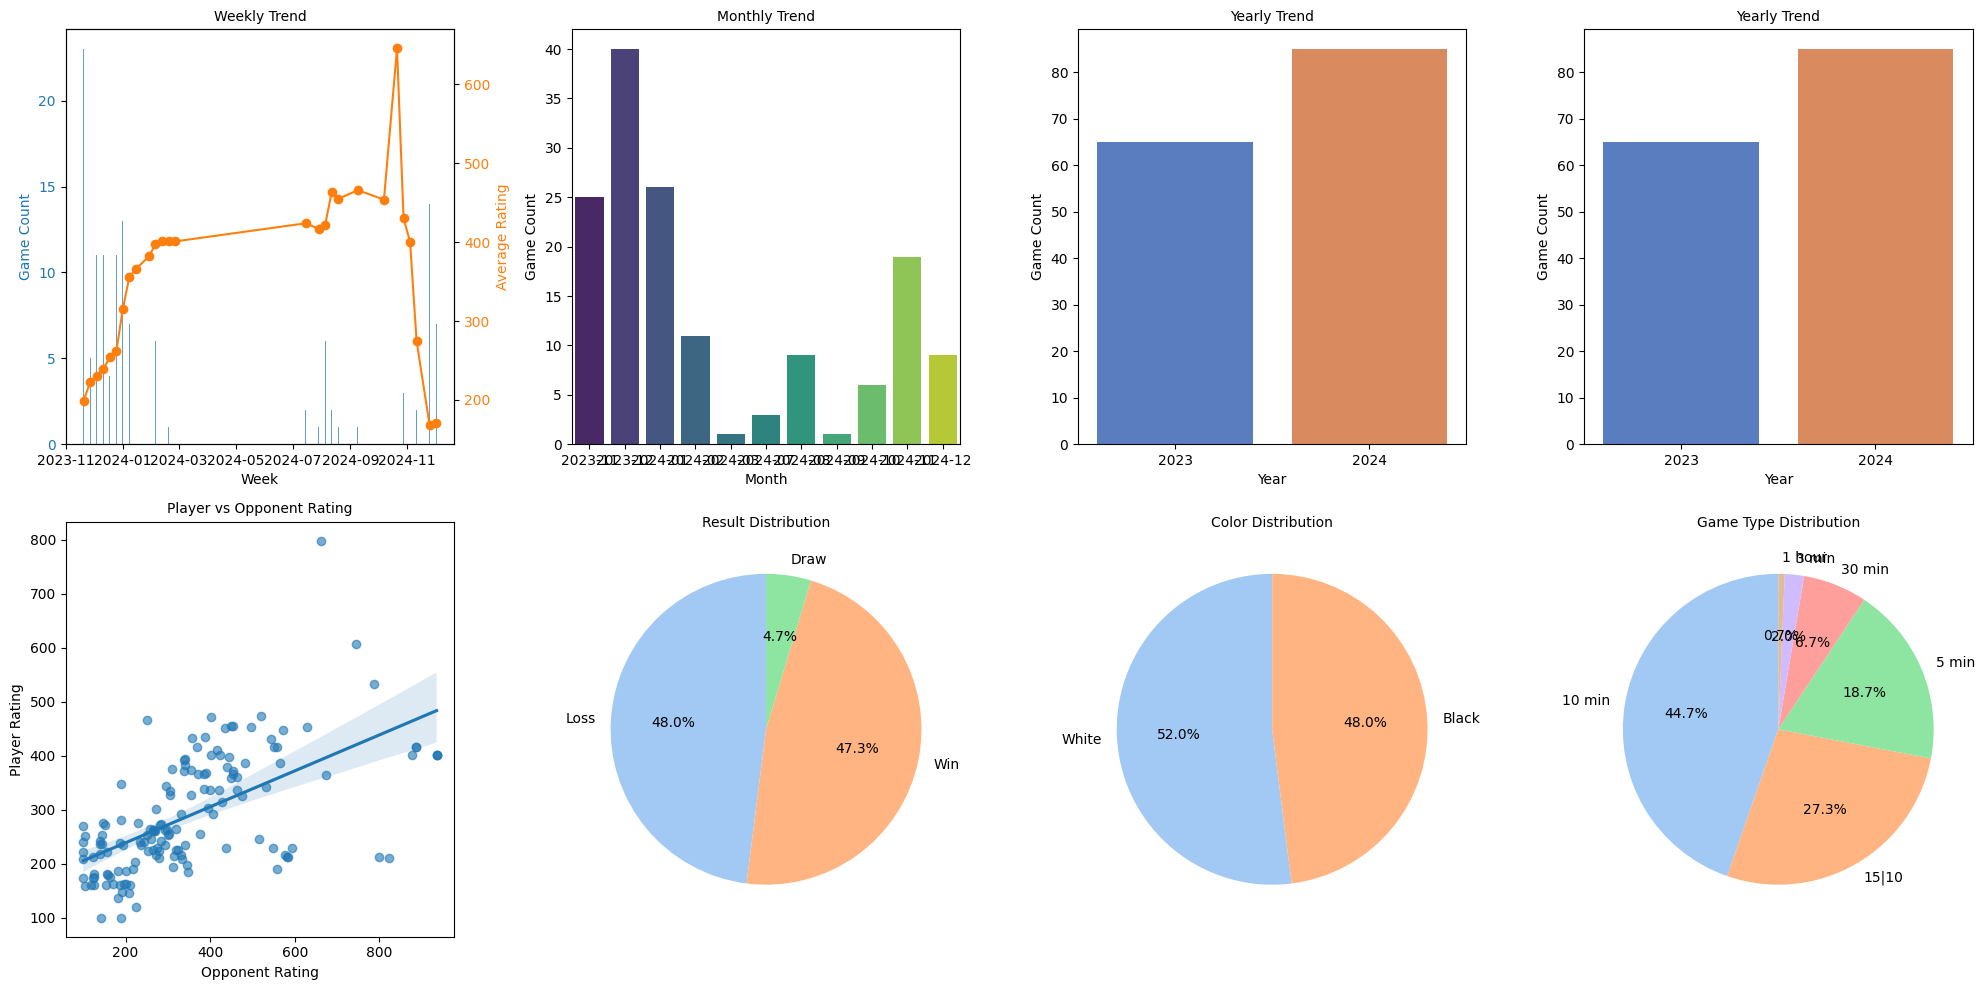

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame

# Convert 'Date' to datetime if not already done
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')

# Ensure 'Player_currentRating' and 'Opponent_currentRating' are numeric
merged_df['Player_currentRating'] = pd.to_numeric(merged_df['Player_currentRating'], errors='coerce')
merged_df['Opponent_currentRating'] = pd.to_numeric(merged_df['Opponent_currentRating'], errors='coerce')

# Drop rows with NaN values in critical columns
merged_df = merged_df.dropna(subset=['Player_currentRating', 'Opponent_currentRating', 'Date'])

# Convert 'Player_currentRating' to integer (optional)
merged_df['Player_currentRating'] = merged_df['Player_currentRating'].astype(int)

# Extract additional time-based information
merged_df['DayOfWeek'] = merged_df['Date'].dt.day_name()
merged_df['Month'] = merged_df['Date'].dt.to_period('M').astype(str)  # Format: YYYY-MM
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Week'] = merged_df['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Weekly Trend: Average rating and game counts by week
weekly_stats = merged_df.groupby('Week').agg(
    AvgRating=('Player_currentRating', 'mean'),
    GameCount=('Player_currentRating', 'count')
).reset_index()

# Create subplots for all graphs side by side
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns for the small graphs

# Weekly Trend: Bar and Line Chart (Inserting in axes[0, 0])
ax1 = axes[0, 0]
color1 = 'tab:blue'
ax1.bar(weekly_stats['Week'], weekly_stats['GameCount'], color=color1, alpha=0.7, label='Game Count')
ax1.set_ylabel('Game Count', color=color1, fontsize=10)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlabel('Week', fontsize=10)

# Line chart for average rating
ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.plot(weekly_stats['Week'], weekly_stats['AvgRating'], marker='o', color=color2, label='Avg Rating')
ax2.set_ylabel('Average Rating', color=color2, fontsize=10)
ax2.tick_params(axis='y', labelcolor=color2)
ax1.set_title('Weekly Trend', fontsize=10)

# Monthly Trend: Number of games played per month
monthly_games = merged_df.groupby('Month').size().reset_index(name='GameCount')
ax3 = axes[0, 1]
sns.barplot(x='Month', y='GameCount', data=monthly_games, hue='Month', palette='viridis', ax=ax3, legend=False)
ax3.set_title('Monthly Trend', fontsize=10)
ax3.set_xlabel('Month', fontsize=10)
ax3.set_ylabel('Game Count', fontsize=10)

# Yearly Trend: Number of games played per year
yearly_games = merged_df.groupby('Year').size().reset_index(name='GameCount')
ax4 = axes[0, 2]
sns.barplot(x='Year', y='GameCount', data=yearly_games, hue='Year', palette='muted', ax=ax4, legend=False)
ax4.set_title('Yearly Trend', fontsize=10)
ax4.set_xlabel('Year', fontsize=10)
ax4.set_ylabel('Game Count', fontsize=10)

# Yearly Trend: Number of games played per year
yearly_games = merged_df.groupby('Year').size().reset_index(name='GameCount')
ax4 = axes[0, 3]
sns.barplot(x='Year', y='GameCount', data=yearly_games, hue='Year', palette='muted', ax=ax4, legend=False)
ax4.set_title('Yearly Trend', fontsize=10)
ax4.set_xlabel('Year', fontsize=10)
ax4.set_ylabel('Game Count', fontsize=10)

# Player vs Opponent Rating Scatter Plot
ax5 = axes[1, 0]
sns.regplot(data=merged_df, x='Opponent_currentRating', y='Player_currentRating', scatter_kws={'alpha': 0.6}, ax=ax5)
ax5.set_title('Player vs Opponent Rating', fontsize=10)
ax5.set_xlabel('Opponent Rating', fontsize=10)
ax5.set_ylabel('Player Rating', fontsize=10)

# Pie Chart: Distribution of Results
result_counts = merged_df['Result'].value_counts()
ax6 = axes[1, 1]
ax6.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
ax6.set_title('Result Distribution', fontsize=10)

# Pie Chart: Distribution of Player Colors
color_counts = merged_df['Player_color'].value_counts()
ax7 = axes[1, 2]
ax7.pie(color_counts, labels=color_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
ax7.set_title('Color Distribution', fontsize=10)

# Pie Chart: Distribution of Game Types
game_type_counts = merged_df['Game_Type'].value_counts()
ax8 = axes[1, 3]
ax8.pie(game_type_counts, labels=game_type_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
ax8.set_title('Game Type Distribution', fontsize=10)

# Adjust layout for small graphs
fig.tight_layout()
plt.show()


In [35]:

def save_games_to_csv(games, filename='chess_games.csv'):
    """Save the scraped game data to a CSV file."""
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        headers = ['Game_Type', 'Result', 'Accuracies', 'Total_Moves', 'Date', 'Link', 
                   'Player1', 'Player1_Rating', 'Player1_Country', 'Player1_Username', 
                   'Player1_Color', 'Player1_Accuracy', 'Player1_Moves', 'Player2', 'Player2_Rating', 
                   'Player2_Country', 'Player2_Username', 'Player2_Color', 'Player2_Accuracy', 'Player2_Moves']
        writer.writerow(headers)

        for game in games:
            if game.get('Player_Details') is None:
                print("BUGGGG")
                continue  # Skip this game if player details are missing or None

            player1, player2 = game['Player_Details'].keys()

            # Handle None for accuracy values
            player1_accuracy = game['Player_Details'][player1].get('accuracy', 'N/A')
            player2_accuracy = game['Player_Details'][player2].get('accuracy', 'N/A')


            row = [
                game['Game_Type'], game['Result'], game['Accuracies'], game['Total_Moves'], 
                game['Date'], game['Link'],
                player1, game['Player_Details'][player1]['currentRating'], 
                game['Player_Details'][player1]['country'], game['Player_Details'][player1]['username'], 
                game['Player_Details'][player1]['color'], player1_accuracy, player1_moves,
                player2, game['Player_Details'][player2]['currentRating'], 
                game['Player_Details'][player2]['country'], game['Player_Details'][player2]['username'], 
                game['Player_Details'][player2]['color'], player2_accuracy, player2_moves
            ]
            writer.writerow(row)

In [36]:
save_games_to_csv(merged_dict)

NameError: name 'player1_moves' is not defined

In [ ]:
print(merged_dict)

In [ ]:
#note to ed the countries are wrong and switched atm